In [1]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 13.8 MB/s eta 0:00:00


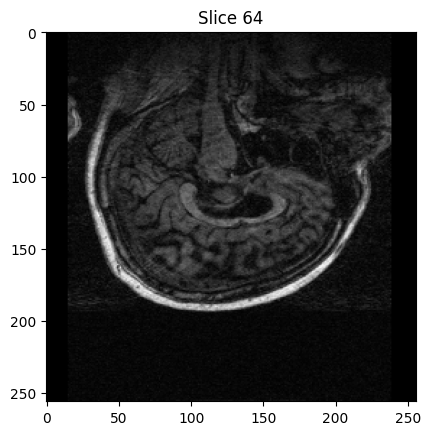

In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Ruta a tu archivo NIfTI (.hdr o .img)
nifti_path = '/content/RAW/mpr-3.nifti.hdr'

# Cargar la imagen NIfTI
image = sitk.ReadImage(nifti_path)

# Convertir a array para visualización
image_array = sitk.GetArrayFromImage(image)

# Obtener información de la imagen
dimension = image.GetDimension()  # Dimensiones (e.g. 3D)
size = image.GetSize()  # Resolución (tamaño de cada eje)
spacing = image.GetSpacing()  # Espaciado físico entre píxeles
depth = image.GetPixelIDValue()  # Tipo de pixel (se usa para determinar el número de bits)
quantization_levels = 2**image.GetPixelIDValue()  # Niveles de cuantización (asumiendo 2^bits)

# Mostrar la imagen, seleccionando una rebanada específica (por ejemplo, la número 64)
plt.imshow(image_array[63, :, :], cmap='gray')
plt.title(f'Slice 64')
plt.show()

# Imprimir la información adicional
print(f'Dimensiones: {dimension}')
print(f'Tamaño (resolución en cada eje): {size}')
print(f'Espaciado entre píxeles: {spacing}')
print(f'Tipo de pixel (ID): {depth}')
print(f'Niveles de cuantización: {quantization_levels}')
print(f'Número de canales: {1 if image.GetNumberOfComponentsPerPixel() == 1 else image.GetNumberOfComponentsPerPixel()}')



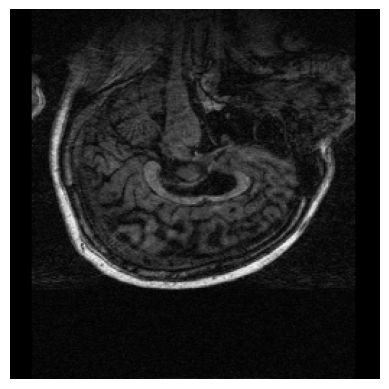

In [13]:
plt.imshow(image_array[63, :, :], cmap='gray')
plt.axis('off')  # Para quitar los ejes
plt.savefig('/content/corte_64.png', bbox_inches='tight', pad_inches=0)
plt.show()


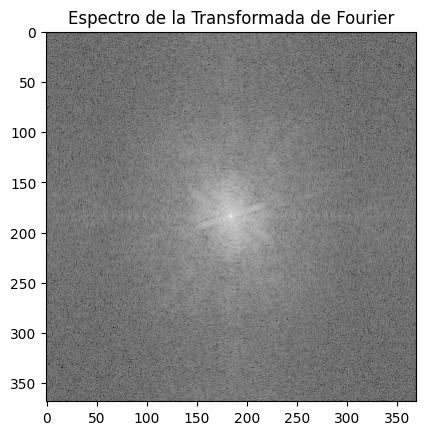

In [14]:
import numpy as np
from PIL import Image

imagen = Image.open('/content/corte_64.png')


array = np.array(imagen)
if array.ndim == 3 and array.shape[2] >= 3:
    arrayGris = np.dot(array[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
else:
    arrayGris = array

imagenGris = (arrayGris // 15) * 15


# Aplicar la Transformada de Fourier 2D
fourier = np.fft.fft2(imagenGris)
# Shift para desplazar las frecuencias bajas al centro del espectro
fourierShift = np.fft.fftshift(fourier)

# Calcular el espectro de magnitudes y Log para comprimir los valores (ayuda a manejar la amplia gama de valores en el espectro)
espectro = np.log(np.abs(fourierShift) + 1)

plt.imshow(espectro, cmap='gray')
plt.title('Espectro de la Transformada de Fourier')
plt.show()

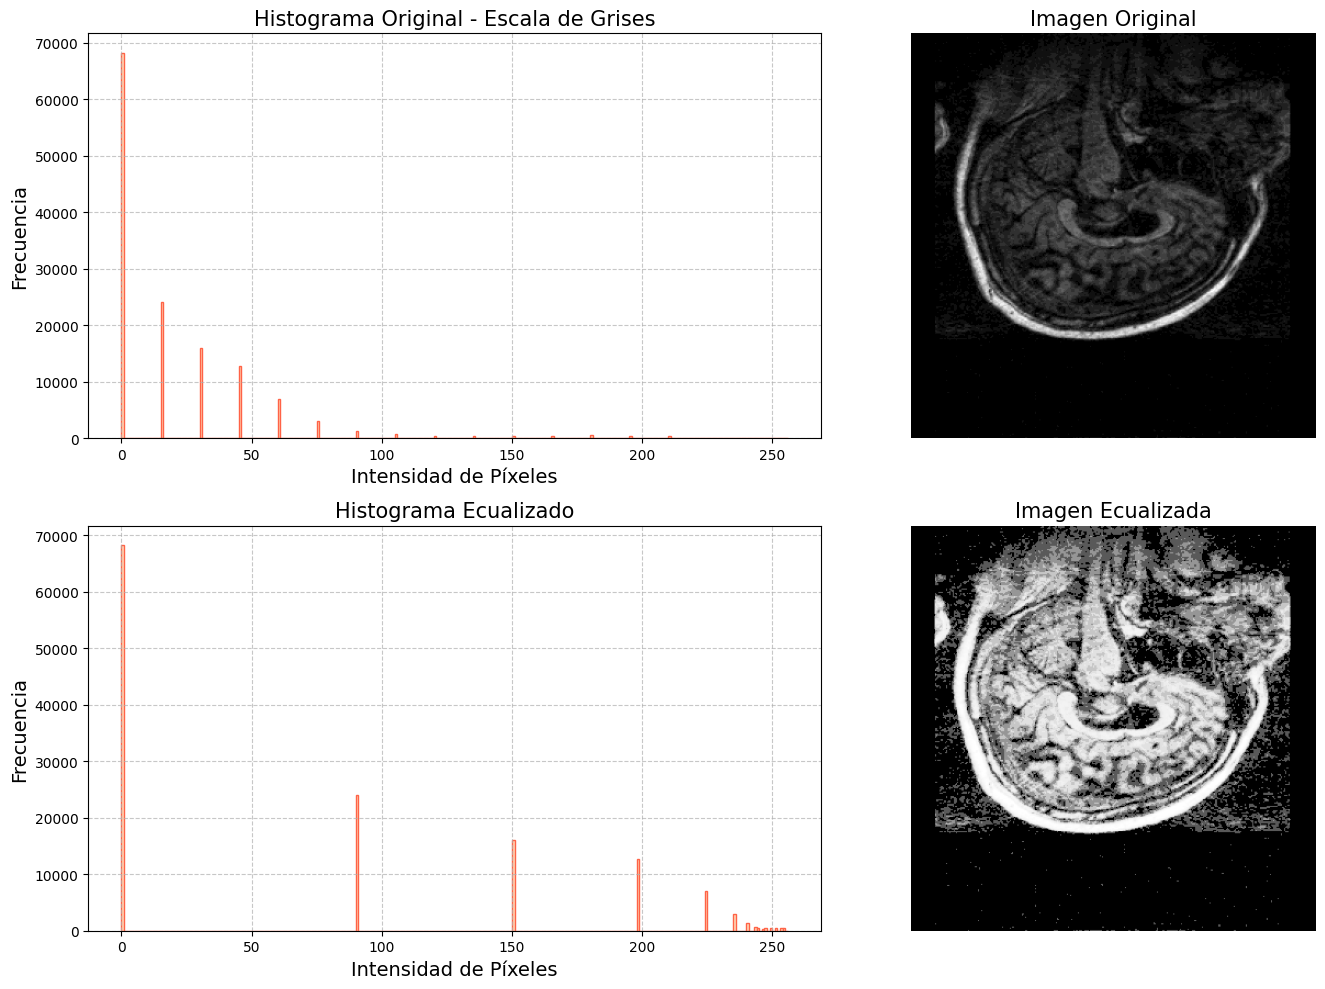

In [15]:
# Función para ecualización del histograma
def ecualizar_histograma(imagen):
    # Calcular el histograma
    histograma, bins = np.histogram(imagen.flatten(), bins=256, range=[0,256])

    # Calcular el histograma acumulado (CDF)
    cdf = histograma.cumsum()

    # Normalizar el CDF para que sus valores estén entre 0 y 255
    cdf_normalizado = 255 * (cdf - cdf.min()) / (cdf.max() - cdf.min())

    # Aplicar la transformación de ecualización
    imagen_ecualizada = np.interp(imagen.flatten(), bins[:-1], cdf_normalizado)

    return imagen_ecualizada.reshape(imagen.shape)

# Aplicar la ecualización del histograma
imagen_ecualizada = ecualizar_histograma(imagenGris)

# Visualizar los histogramas y las imágenes
plt.figure(figsize=(15, 10))

# Histograma de la imagen original
plt.subplot(2, 2, 1)
plt.title('Histograma Original - Escala de Grises', fontsize=15)
plt.hist(imagenGris.ravel(), bins=256, range=(0, 256), color='peachpuff', edgecolor='tomato')
plt.xlabel('Intensidad de Píxeles', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Imagen original
plt.subplot(2, 2, 2)
plt.title("Imagen Original", fontsize=15)
plt.imshow(imagenGris, cmap='gray')
plt.axis('off')

# Histograma de la imagen ecualizada
plt.subplot(2, 2, 3)
plt.title('Histograma Ecualizado', fontsize=15)
plt.hist(imagen_ecualizada.ravel(), bins=256, range=(0, 256), color='peachpuff', edgecolor='tomato')
plt.xlabel('Intensidad de Píxeles', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Imagen ecualizada
plt.subplot(2, 2, 4)
plt.title("Imagen Ecualizada", fontsize=15)
plt.imshow(imagen_ecualizada, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Convertir la imagen ecualizada a tipo uint8 (es necesario para guardar la imagen correctamente)
imagen_uint8 = imagen_ecualizada.astype(np.uint8)

# Crear una imagen de PIL desde el array
imagen_pil = Image.fromarray(imagen_uint8)

# Guardar la imagen ecualizada en formato PNG o el formato que prefieras
imagen_pil.save('/content/imagen_ecualizada.png')


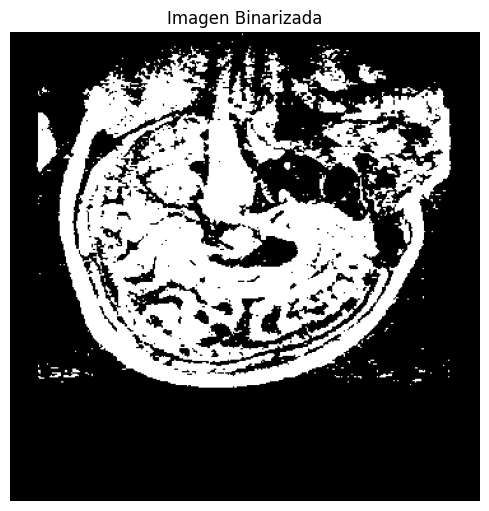

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure
from PIL import Image

imagen = Image.open('/content/imagen_ecualizada.png')

array = np.array(imagen)

imagenGris = array

# Umbral para binarizar la imagen (según la intensidad)
umbral = 128  # Ajusta este valor según sea necesario
imagen_binaria = imagenGris > umbral

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 2)
plt.imshow(imagen_binaria, cmap='gray')
plt.title("Imagen Binarizada")
plt.axis('off')


plt.tight_layout()
plt.show()

Región 1:
 - Área: 1.0
 - Perímetro: 0.0
 - Centroide: (2.0, 182.0)
 - Bounding box: (2, 182, 3, 183)

Región 2:
 - Área: 1.0
 - Perímetro: 0.0
 - Centroide: (8.0, 174.0)
 - Bounding box: (8, 174, 9, 175)

Región 3:
 - Área: 2.0
 - Perímetro: 0.0
 - Centroide: (9.0, 163.5)
 - Bounding box: (9, 163, 10, 165)

Región 4:
 - Área: 2.0
 - Perímetro: 0.0
 - Centroide: (11.0, 241.5)
 - Bounding box: (11, 241, 12, 243)

Región 5:
 - Área: 1.0
 - Perímetro: 0.0
 - Centroide: (11.0, 249.0)
 - Bounding box: (11, 249, 12, 250)

Región 6:
 - Área: 1.0
 - Perímetro: 0.0
 - Centroide: (12.0, 129.0)
 - Bounding box: (12, 129, 13, 130)

Región 7:
 - Área: 12.0
 - Perímetro: 9.207106781186548
 - Centroide: (15.416666666666666, 143.25)
 - Bounding box: (12, 142, 19, 146)

Región 8:
 - Área: 1.0
 - Perímetro: 0.0
 - Centroide: (12.0, 188.0)
 - Bounding box: (12, 188, 13, 189)

Región 9:
 - Área: 1.0
 - Perímetro: 0.0
 - Centroide: (12.0, 246.0)
 - Bounding box: (12, 246, 13, 247)

Región 10:
 - Área: 1.0


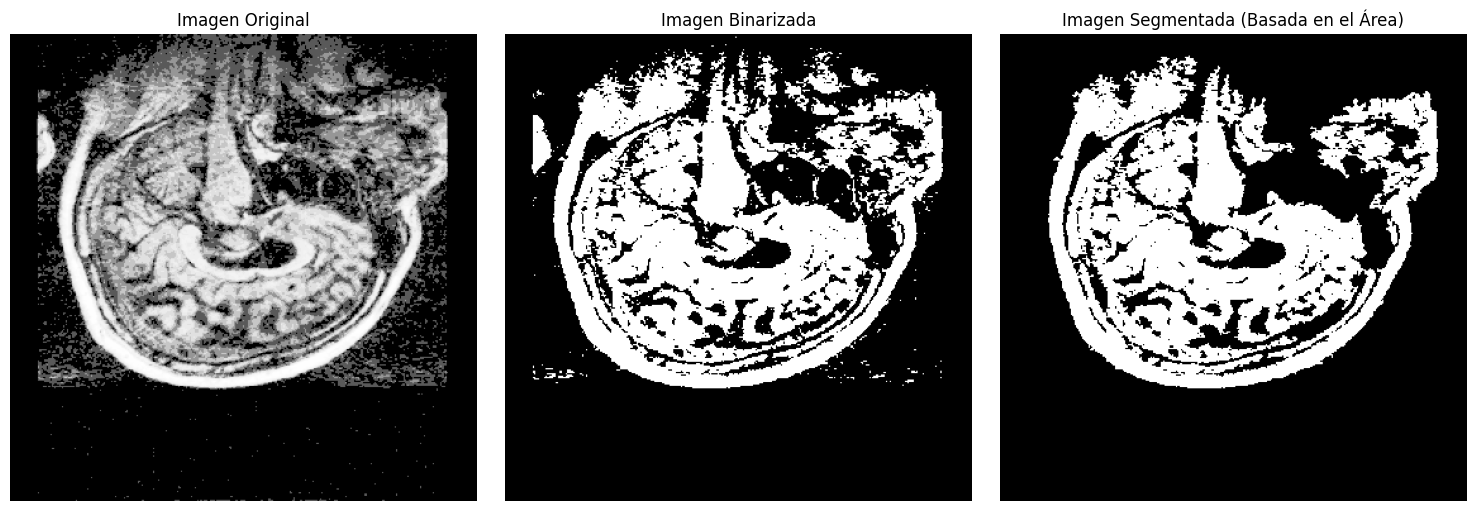

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure
from PIL import Image

imagen = Image.open('/content/imagen_ecualizada.png')

array = np.array(imagen)

imagenGris = array

# Umbral para binarizar la imagen (según la intensidad)
umbral = 128  # Ajusta este valor según sea necesario
imagen_binaria = imagenGris > umbral

# Etiquetado de componentes conectados
etiquetas, num_regiones = ndimage.label(imagen_binaria)

# Extraer las propiedades de las regiones etiquetadas
propiedades = measure.regionprops(etiquetas)

# Mostrar algunas propiedades de las regiones
for i, region in enumerate(propiedades):
    print(f"Región {i+1}:")
    print(f" - Área: {region.area}")
    print(f" - Perímetro: {region.perimeter}")
    print(f" - Centroide: {region.centroid}")
    print(f" - Bounding box: {region.bbox}")
    print()

# Crear una nueva imagen para la segmentación basada en las propiedades de las regiones
# En este caso, solo vamos a mantener las regiones que tienen un área mayor que un umbral
area_minima = 500  # Puedes ajustar este valor según el tamaño de las regiones
imagen_segmentada = np.zeros_like(imagenGris)

for region in propiedades:
    if region.area >= area_minima:
        # Mantener la región si el área es mayor que el umbral
        for coords in region.coords:
            imagen_segmentada[coords[0], coords[1]] = 255  # Pintar las regiones segmentadas de blanco

# Mostrar la imagen original, binarizada y segmentada
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(imagenGris, cmap='gray')
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(imagen_binaria, cmap='gray')
plt.title("Imagen Binarizada")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(imagen_segmentada, cmap='gray')
plt.title("Imagen Segmentada (Basada en el Área)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Convertir la imagen ecualizada a tipo uint8 (es necesario para guardar la imagen correctamente)
imagen_uint8 = imagen_segmentada.astype(np.uint8)

# Crear una imagen de PIL desde el array
imagen_pil = Image.fromarray(imagen_uint8)

# Guardar la imagen ecualizada en formato PNG o el formato que prefieras
imagen_pil.save('/content/imagen_segmentada.png')

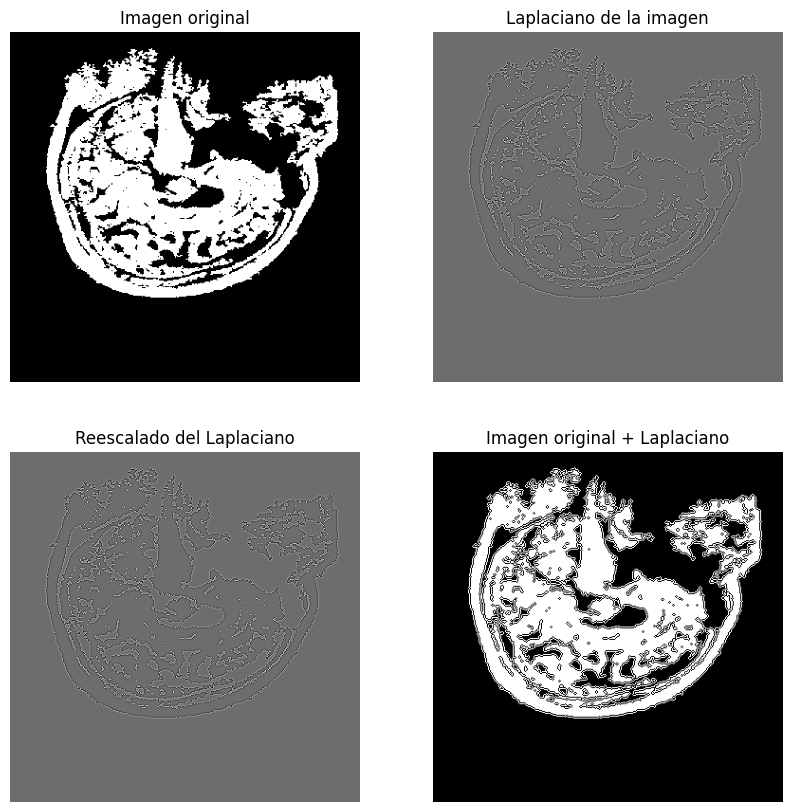

In [20]:
# Función para aplicar un filtro laplaciano
def aplicar_filtro_laplaciano(imagen):
    # Kernel Laplaciano 3x3
    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])

    # Tamaño de la imagen
    filas, columnas = imagen.shape

    # Crear imagen filtrada con ceros
    imagen_filtrada = np.zeros((filas, columnas))

    # Aplicar convolución
    for i in range(1, filas-1):
        for j in range(1, columnas-1):
            suma = 0
            for ki in range(-1, 2):
                for kj in range(-1, 2):
                    suma += imagen[i+ki, j+kj] * kernel[ki+1, kj+1]
            imagen_filtrada[i, j] = suma

    return imagen_filtrada

def normalizar_imagen(imagen):
    return (imagen - imagen.min()) * (255 / (imagen.max() - imagen.min()))



# Mostrar las imágenes
def mostrar_imagenes(imagen_original, laplaciano, imagen_resultante):
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(imagen_original, cmap='gray')
    plt.title("Imagen original")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(laplaciano, cmap='gray')
    plt.title("Laplaciano de la imagen")
    plt.axis('off')

    plt.subplot(2, 2, 3)
    laplaciano_normalizado = normalizar_imagen(laplaciano)
    plt.imshow(laplaciano_normalizado, cmap='gray')
    plt.title("Reescalado del Laplaciano")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    imagen_con_laplaciano = np.clip(imagen_original + laplaciano, 0, 255)
    plt.imshow(imagen_con_laplaciano, cmap='gray')
    plt.title("Imagen original + Laplaciano")
    plt.axis('off')

    plt.show()

# Ruta de la imagen cargada
ruta_imagen = '/content/imagen_segmentada.png'

# Leer la imagen y procesarla
imagen = Image.open(ruta_imagen)


array = np.array(imagen)
if array.ndim == 3 and array.shape[2] >= 3:
    arrayGris = np.dot(array[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
else:
    arrayGris = array

imagenGris = (arrayGris // 15) * 15

laplaciano_imagen = aplicar_filtro_laplaciano(imagenGris)

# Mostrar las imágenes
mostrar_imagenes(imagenGris, laplaciano_imagen, imagenGris + laplaciano_imagen)

